# Detecting Spam Emails Using Tensorflow

Spam messages are unsolicited or unwanted emails/messages sent in bulk to users. Detecting spam emails automatically helps prevent unnecessary clutter in users' inboxes.

In this article, we will build a **spam email detection model that classifies emails as Spam or Ham (Not Spam)** using **TensorFlow**, one of the most popular deep learning libraries.

## 1: Import Required Libraries

Before we begin let’s import the necessary libraries: `pandas`, `numpy`, `tensorflow`, `matplotlib`, `wordcloud`, `nltk` for data processing, model building, and visualization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2: Load the Dataset

We’ll use a dataset containing labeled emails (Spam or Ham). Let’s load the dataset and inspect its structure. You can download the dataset from [here](https://media.geeksforgeeks.org/wp-content/uploads/20250320162008521713/spam_ham_dataset.csv):

In [4]:
data = pd.read_csv('/content/drive/MyDrive/04_Spam_Detection/data/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


This will give us a glimpse into the first few rows of the dataset. You can also check the shape of the dataset:

In [6]:
data.shape

(5171, 4)

The data contains 5171 rows and four columns.

Now, let's visualize the label distribution to get understanding of the class distribution:

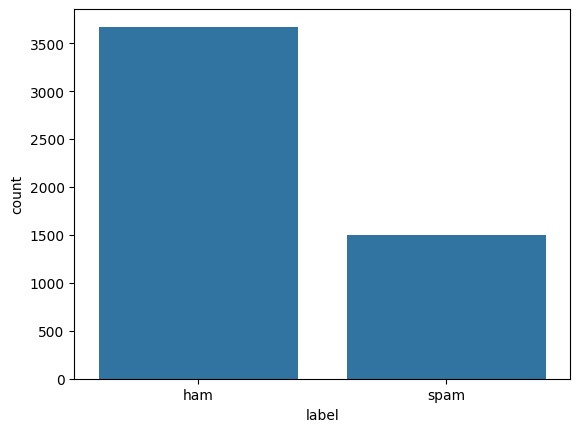

In [7]:
sns.countplot(x='label', data=data)
plt.show()

##3: Balance the Dataset

We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. To address the imbalance we’ll downsample the majority class (Ham) to match the minority class (Spam).

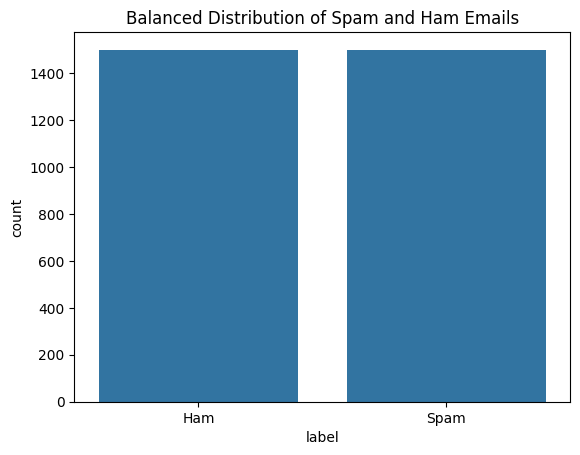

In [8]:
ham_msg = data[data['label']=='ham']
spam_msg = data[data['label']=='spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine the balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced data
sns.countplot(x='label', data=balanced_data)
plt.title(("Balanced Distribution of Spam and Ham Emails"))
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'])
plt.show()

##4: Clean the Text

Textual data often requires preprocessing before feeding it into a machine learning model. Common steps include removing stopwords, punctuations, and performing stemming/lemmatization.

We’ll perform the following steps:

* Stopwords Removal
* Punctuations Removal
* Stemming or Lemmatization

Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [9]:
balanced_data

,Unnamed: 0,label,text,label_num
0,3444,ham,Subject: conoco - big cowboy\r\ndarren :\r\ni ...,0
1,2982,ham,Subject: feb 01 prod : sale to teco gas proces...,0
2,2711,ham,Subject: california energy crisis\r\ncaliforni...,0
3,3116,ham,Subject: re : nom / actual volume for april 23...,0
4,1314,ham,Subject: eastrans nomination changes effective...,0
...,...,...,...,...
2993,4381,spam,Subject: pictures\r\nstreamlined denizen ajar ...,1
2994,4979,spam,Subject: penny stocks are about timing\r\nnoma...,1
2995,4162,spam,Subject: anomaly boys from 3881\r\nuosda apapr...,1
2996,4365,spam,Subject: slutty milf wants to meet you\r\ntake...,1


In [10]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', "")
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [20]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


The below function is a helper function that will help us to remove the stop words.


In [21]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')

  imp_words = []

  # Storing the important words
  for word in str(text).split():
    word = word.lower()

    if word not in stop_words:
      imp_words.append(word)

  output = " ".join(imp_words)

  return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


## Visualize Word Cloud

A word cloud is a text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

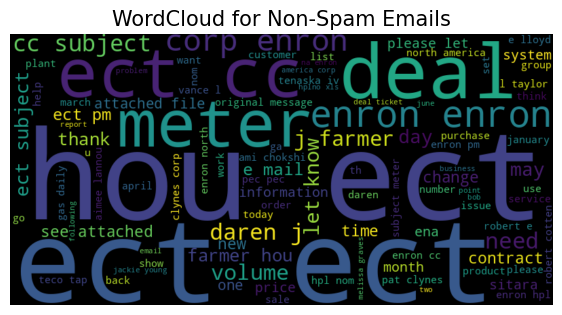

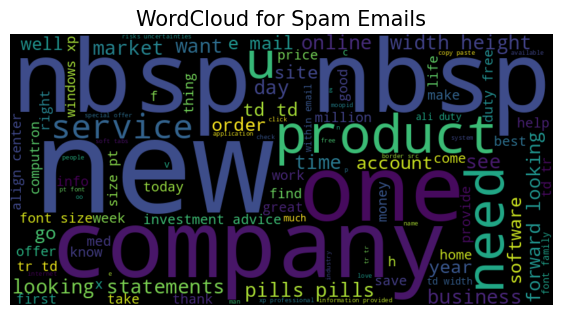

In [22]:
from tkinter import font
def plot_word_cloud(data, typ):
  email_corpus = " ".join(data['text'])
  wc = WordCloud(background_color = 'black', max_words=100, width=800, height=400).generate(email_corpus)
  plt.figure(figsize=(7,7))
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'WordCloud for {typ} Emails', fontsize=15)
  plt.axis('off')
  plt.show()

plot_word_cloud(balanced_data[balanced_data['label']=='ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label']=='spam'],typ='Spam')

## 6: Tokenization and Padding

Machine learning models work with numbers, so we need to convert the text data into numerical vectors using Tokenization and Padding.

* Tokenization: Converts each word into a unique integer.
* Padding: Ensures that all text sequences have the same length, making them compatible with the model.

In [23]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

##7: Define the Model

We will build a deep learning model using a Sequential architecture. This model will include:

* Embedding Layer: Learns vector representations of words.
* LSTM Layer: Captures patterns in sequences.
* Fully Connected Layer: Extracts relevant features.
* Output Layer: Predicts whether an email is spam or not.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##8: Train the Model

We train the model using EarlyStopping and ReduceLROnPlateau callbacks. These callbacks help stop the training early if the model’s performance doesn’t improve and reduce the learning rate to fine-tune the model.

In [25]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5776 - loss: 0.6793 - val_accuracy: 0.9617 - val_loss: 0.2256 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9425 - loss: 0.2181 - val_accuracy: 0.9383 - val_loss: 0.2023 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9546 - loss: 0.1600 - val_accuracy: 0.9533 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9699 - loss: 0.1222 - val_accuracy: 0.9633 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9710 - loss: 0.1249 - val_accuracy: 0.9717 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9763 - loss: 0.1079 - val_accuracy: 0.9750 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9834 - loss: 0.0795 - val_accuracy:

After training, we evaluate the model on the test data to measure its performance.

In [28]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9747 - loss: 0.1155
Test Loss : 0.11669015139341354
Test Accuracy : 0.9750000238418579


Thus, the training accuracy turns out to be 97% which is quite satisfactory.

Having trained our model, we can plot a graph depicting the variance of training and validation accuracies with the no. of epochs.

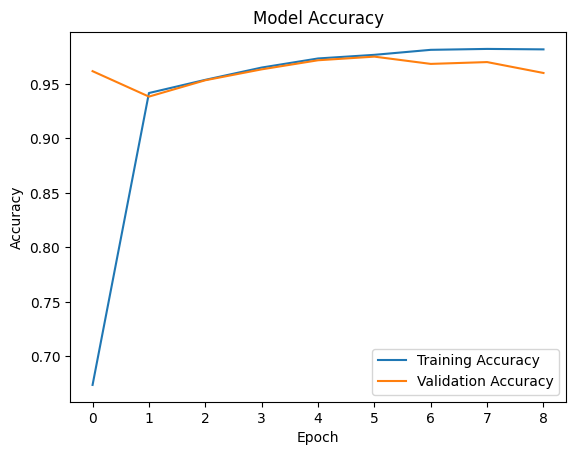

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()